# **Elaborated by : Amine Sellami**,**Selim Ksous**  &  **Ahmed Ouertani**  




---



# Introduction

Optimizing the supply chain management has always been a critical subject since a deviation from the optimal solution could definitely present a huge cost. Recently, researches tends to use different algorithms, mainly metaheuristic algorithms, in order to reduce the objective function which takes into account several parameters like cost, quantities, etc.. In our scope of work, we have chosen to use ACO algorithm for this problem. Our work is supported by the paper named **Development of an ant colony optimisation-based heuristic for a location-routing problem in a two-stage supply chain**, published in **2018** by **Vinay V. Panicker**, **M. Vamshidhar Reddy** and **R. Sridharan**.

This problem is a two stage location-routing problem (LRP), which takes into account the plant, depots and customers.

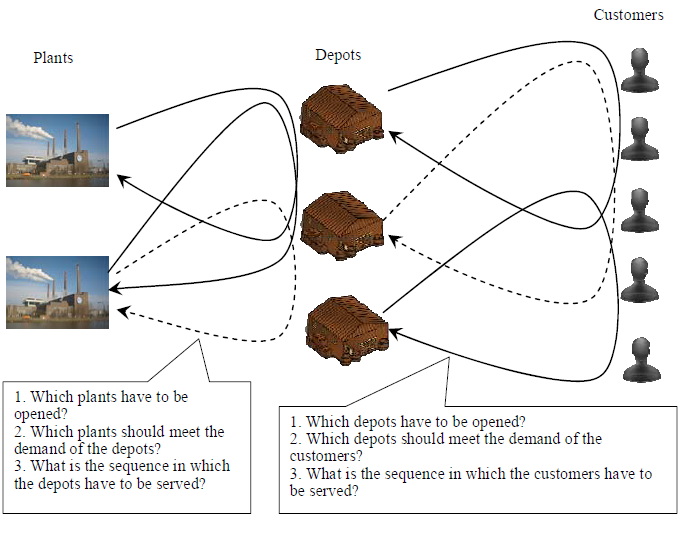

# Problem description

* The supply chain network presents multiple plants, multiple depots and multiple customers. Each has its capacities and demands.
* We are considering the limitation of plants and depot.
* The distance between each single part is predetermined.
* All the vehicles have the same capacity.
* Vehicle capacity is considered only for the depot to customer phase of the problem.
* Individual demand of each customer cannot exceed the capacity of a vehicle.
* The entire demand of the depot or the customer is met by a single vehicle.

# Ant Colony Optimization (ACO) Mathematical Model

### 1. Representation of the Problem

Consider a graph $ G = (N, E) $, where $ N $ is the set of nodes and $ E $ is the set of edges.

### 2. Pheromone Update

Each edge  $ (i, j) \in E $ has an associated pheromone level $ \tau_{ij}(t) $ at time $ t $.

### 3. Ants’ Movement Probability

The probability $ p_{ij}^k(t) $ that an ant $ k $ at node $ i $ moves to node $ j $ at time $ t $ is given by:

$$
p_{ij}^k(t) = \frac{\left[ \tau_{ij}(t) \right]^\alpha \left[ \eta_{ij} \right]^\beta}{\sum_{l \in N_i} \left[ \tau_{il}(t) \right]^\alpha \left[ \eta_{il} \right]^\beta}
$$

where:

- $ \tau_{ij}(t)$  is the pheromone level on edge $(i, j)$ at time $t$
- $ \eta_{ij} = \frac{1}{d_{ij}} $ is the heuristic desirability of moving from node $ i $ to node $ j $.
- $ \alpha $ and $ \beta $ are parameters that control the relative importance of pheromone versus heuristic information.
- $ N_i $ is the set of nodes adjacent to node $ i $.

### 4. Pheromone Update Rule

After all ants have constructed their solutions, the pheromone levels are updated according to:

$$
\tau_{ij}(t+1) = (1 - \rho) \tau_{ij}(t) + \Delta \tau_{ij}(t)
$$

where:

- $ \rho $ is the pheromone evaporation rate (0 < $ \rho $ < 1).
- $ \Delta \tau_{ij}(t) $ is the amount of pheromone deposited, typically given by:

$$
\Delta \tau_{ij}(t) = \sum_{k=1}^m \Delta \tau_{ij}^k(t)
$$

- $ \Delta \tau_{ij}^k(t) $ is the pheromone deposited by ant $ k $ on edge $ (i, j) $:

$$
\Delta \tau_{ij}^k(t) = \begin{cases}
\frac{Q}{L_k} & \text{if ant } k \text{ uses edge } (i, j) \text{ in its tour} \\
0 & \text{otherwise}
\end{cases}
$$

- $ Q $ is a constant, and $ L_k $ is the length of the tour constructed by ant $ k $.


# Implementation

The Flow chart for ACO-based heuristic is given by :

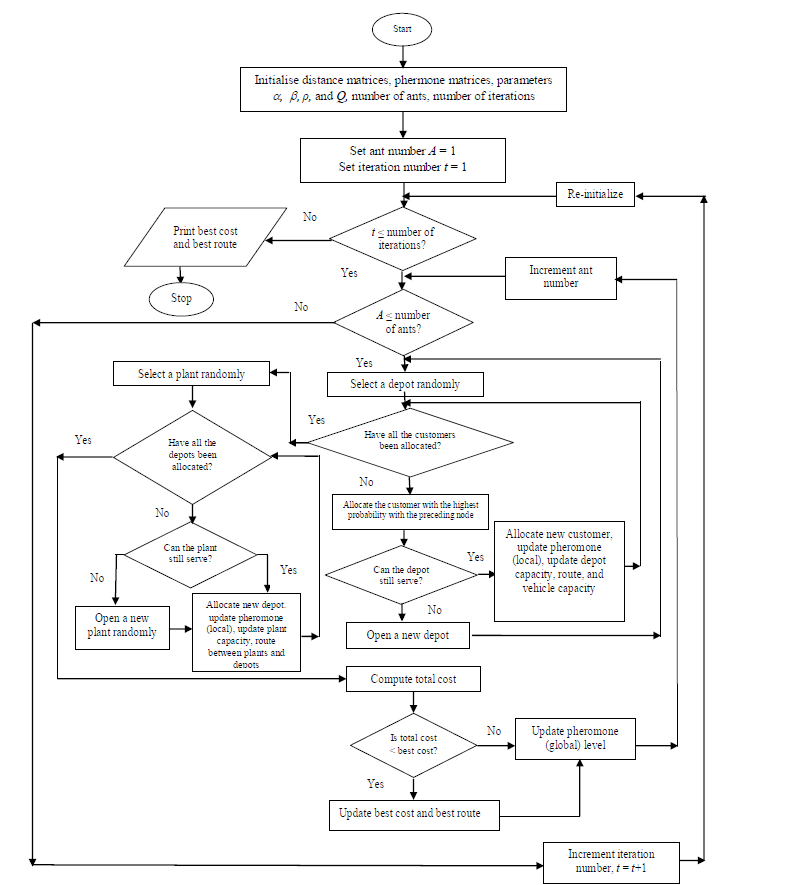

In our implemntation, we will use a class named **AntColonyOptimization**, in the init we will take into consideration each constraint that we mentionned previously. The function are as follows:
* **calculate_probabilities**: which use the formula in the previous section, 3. Ants'Movement Probability
* **run**: which determines the optimal solution and returns the best one with the best cost
* **construct solution** : which determines the next depot and customer in each iteration
* **calculate_cost**: which calculate the cost for each possibility, from depot to customer and from plant to depot
* **update_pheromones**: which update the pheromones using the formula in the previous section, 4. Pheromone Update Rule

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random


pd.options.display.max_rows
pd.set_option('display.max_rows', None)
pd.options.display.max_columns
pd.set_option('display.max_columns', None)

In [2]:
class AntColonyOptimization:
    def __init__(self, num_customers, num_depots, num_plants, vehicle_capacity, depot_capacity, plant_capacity, distance_depot_to_customer, distance_plant_to_depot,
                 demand_customers,num_ants, num_iterations, alpha=1.0, beta=2.0, evaporation_rate=0.5, pheromone_initial=0.5,Q=1):
        self.num_customers = num_customers
        self.num_depots = num_depots
        self.num_plants = num_plants
        self.vehicle_capacity = vehicle_capacity
        self.depot_capacity = depot_capacity
        self.plant_capacity = plant_capacity
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.pheromone_initial = pheromone_initial

        self.distance_depot_to_customer = distance_depot_to_customer
        self.distance_plant_to_depot = distance_plant_to_depot
        self.demand_customers = demand_customers

        self.pheromone_depot_to_customer = np.full((num_depots, num_customers), pheromone_initial) # [[pheromone_initial pheromone_initial ..]  [.. ... ..]]
        self.pheromone_plant_to_depot = np.full((num_plants, num_depots), pheromone_initial)

    def calculate_probabilities(self, pheromone, visibility):
        prob_matrix = (pheromone ** self.alpha) * (visibility ** self.beta)
        prob_matrix /= prob_matrix.sum(axis=1, keepdims=True)
        return prob_matrix

    def run(self):
        best_solution = None
        best_cost = float('inf')

        for iteration in range(self.num_iterations):
            solutions = []
            for ant in range(self.num_ants):
                solution = self.construct_solution()
                solutions.append(solution)

            for solution in solutions:
                cost = self.calculate_cost(solution)
                if cost < best_cost:
                    best_cost = cost
                    best_solution = solution

                self.update_pheromones(solution, cost)

        return best_solution, best_cost

    def construct_solution(self):
        solution = {'depot_to_customer': [], 'plant_to_depot': []}
        current_depot = random.randint(0, self.num_depots - 1)
        remaining_capacity = self.vehicle_capacity
        customers_served = np.zeros(self.num_customers, dtype=bool)

        visibility_depot_to_customer = 1.0 / self.distance_depot_to_customer
        probabilities_depot_to_customer = self.calculate_probabilities(self.pheromone_depot_to_customer, visibility_depot_to_customer)

        # Stage 1: Route from depots to customers
        while not all(customers_served):
            available_customers = np.where(~customers_served)[0] # customers that have not been served yet
            prob = probabilities_depot_to_customer[current_depot, available_customers]
            selected_customer = np.random.choice(available_customers, p=prob / prob.sum())
            solution['depot_to_customer'].append((current_depot, selected_customer))
            remaining_capacity -= self.demand_customers[selected_customer]
            customers_served[selected_customer] = True

            if remaining_capacity < 0:
                current_depot = random.randint(0, self.num_depots - 1)
                remaining_capacity = self.vehicle_capacity

        # Stage 2: Route from plants to depots
        demand_at_depots = np.zeros(self.num_depots)
        for depot, customer in solution['depot_to_customer']:
            demand_at_depots[depot] += self.demand_customers[customer]

        visibility_plant_to_depot = 1.0 / self.distance_plant_to_depot
        probabilities_plant_to_depot = self.calculate_probabilities(self.pheromone_plant_to_depot, visibility_plant_to_depot)

        for depot in range(self.num_depots):
            current_plant = random.randint(0, self.num_plants - 1)
            remaining_capacity = self.plant_capacity
            while demand_at_depots[depot] > 0:
                prob = probabilities_plant_to_depot[current_plant, depot]
                solution['plant_to_depot'].append((current_plant, depot))
                remaining_capacity -= demand_at_depots[depot]
                demand_at_depots[depot] = 0

                if remaining_capacity < 0:
                    current_plant = random.randint(0, self.num_plants - 1)
                    remaining_capacity = self.plant_capacity

        return solution

    def calculate_cost(self, solution):
        cost = sum(self.distance_depot_to_customer[depot, customer] for depot, customer in solution['depot_to_customer'])
        cost += sum(self.distance_plant_to_depot[plant, depot] for plant, depot in solution['plant_to_depot'])
        return cost

    def update_pheromones(self, solution, cost):
        self.pheromone_depot_to_customer *= (1 - self.evaporation_rate)
        self.pheromone_plant_to_depot *= (1 - self.evaporation_rate)

        for depot, customer in solution['depot_to_customer']:
            self.pheromone_depot_to_customer[depot, customer] += Q / cost
        for plant, depot in solution['plant_to_depot']:
            self.pheromone_plant_to_depot[plant, depot] += Q / cost


# Examples

For all the examples we will use these values, and then we will vary only $\alpha$ and $\beta$ for 3 case study, where we will take random values for the distances between plants and depots, depots and customers

In [7]:
num_customers = 10
num_depots = 3
num_plants = 2
vehicle_capacity = 50
depot_capacity = 200
plant_capacity = 300
num_ants = 10
num_iterations = 100
alpha = 1.0
beta = 2.0
evaporation_rate = 0.5
pheromone_initial = 0.5
Q=1
beta_values = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
alpha_values = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]

## First Example

In [9]:
distance_depot_to_customer1 = np.random.rand(num_depots, num_customers)
distance_plant_to_depot1 = np.random.rand(num_plants, num_depots)
demand_customers1 = np.random.randint(5, 20, size=num_customers)

In [10]:
aco1=AntColonyOptimization(num_customers, num_depots, num_plants, vehicle_capacity, depot_capacity, plant_capacity, distance_depot_to_customer1, distance_plant_to_depot1,
                 demand_customers1,num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_initial)
best_solution1, best_cost1 = aco1.run()
print("Best solution:", best_solution1)
print("Best cost:", best_cost1)

Best solution: {'depot_to_customer': [(1, 5), (1, 1), (1, 8), (1, 3), (2, 9), (2, 7), (2, 0), (2, 2), (0, 4), (0, 6)], 'plant_to_depot': [(1, 0), (1, 1), (0, 2)]}
Best cost: 3.5456988003881627


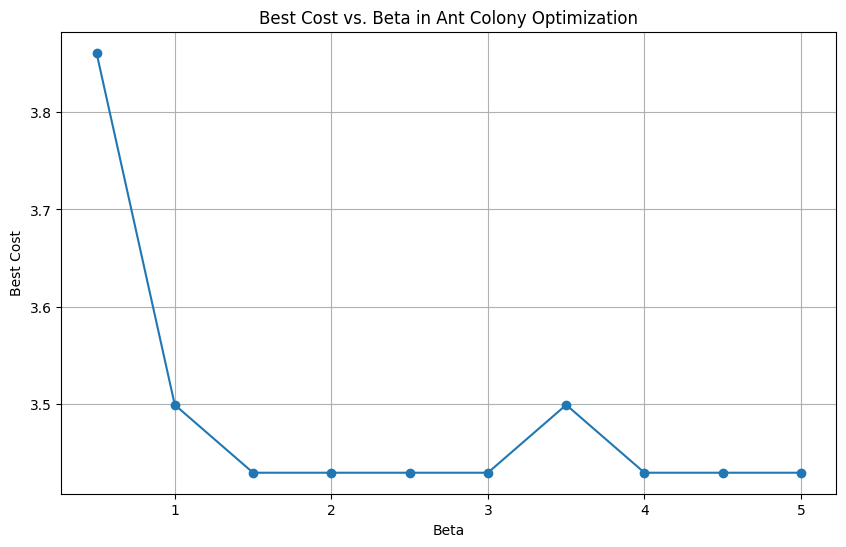

In [11]:
best_costs1 = []
for beta in beta_values:
    aco = AntColonyOptimization(
        num_customers, num_depots, num_plants, vehicle_capacity, depot_capacity, plant_capacity,
        distance_depot_to_customer1, distance_plant_to_depot1, demand_customers1, num_ants,
        num_iterations, alpha, beta, evaporation_rate, pheromone_initial
    )
    best_solution, best_cost = aco.run()
    best_costs1.append(best_cost)

plt.figure(figsize=(10, 6))
plt.plot(beta_values, best_costs1, marker='o', linestyle='-')
plt.xlabel('Beta')
plt.ylabel('Best Cost')
plt.title('Best Cost vs. Beta in Ant Colony Optimization')
plt.grid(True)
plt.show()

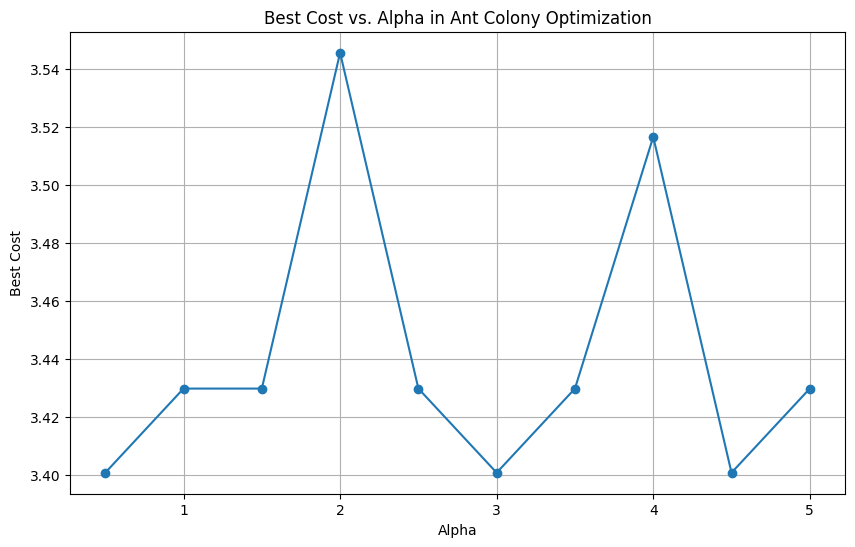

In [14]:
beta=2.0
alpha_costs1 = []
for alpha in alpha_values:
    aco = AntColonyOptimization(
        num_customers, num_depots, num_plants, vehicle_capacity, depot_capacity, plant_capacity,
        distance_depot_to_customer1, distance_plant_to_depot1, demand_customers1, num_ants,
        num_iterations, alpha, beta, evaporation_rate, pheromone_initial
    )
    best_solution, best_cost = aco.run()
    alpha_costs1.append(best_cost)

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, alpha_costs1, marker='o', linestyle='-')
plt.xlabel('Alpha')
plt.ylabel('Best Cost')
plt.title('Best Cost vs. Alpha in Ant Colony Optimization')
plt.grid(True)
plt.show()

In [15]:
aco1=AntColonyOptimization(num_customers, num_depots, num_plants, vehicle_capacity, depot_capacity, plant_capacity, distance_depot_to_customer1, distance_plant_to_depot1,
                 demand_customers1,num_ants, num_iterations, 3, beta, evaporation_rate, pheromone_initial)
best_solution1, best_cost1 = aco1.run()
print("Best solution:", best_solution1)
print("Best cost:", best_cost1)

Best solution: {'depot_to_customer': [(2, 9), (2, 7), (2, 0), (2, 2), (1, 1), (1, 5), (1, 8), (1, 3), (0, 4), (0, 6)], 'plant_to_depot': [(0, 0), (1, 1), (0, 2)]}
Best cost: 3.4297667989747387


## Second Example

In [17]:
distance_depot_to_customer2 = np.random.rand(num_depots, num_customers)
distance_plant_to_depot2 = np.random.rand(num_plants, num_depots)
demand_customers2 = np.random.randint(5, 20, size=num_customers)

In [28]:
aco2=AntColonyOptimization(num_customers, num_depots, num_plants, vehicle_capacity, depot_capacity, plant_capacity, distance_depot_to_customer2, distance_plant_to_depot2,
                 demand_customers2,num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_initial)
best_solution2, best_cost2 = aco2.run()
print("Best solution:", best_solution2)
print("Best cost:", best_cost2)

Best solution: {'depot_to_customer': [(1, 5), (1, 7), (1, 6), (1, 9), (2, 8), (2, 2), (2, 4), (2, 3), (2, 0), (1, 1)], 'plant_to_depot': [(0, 1), (0, 2)]}
Best cost: 3.5001392128695166


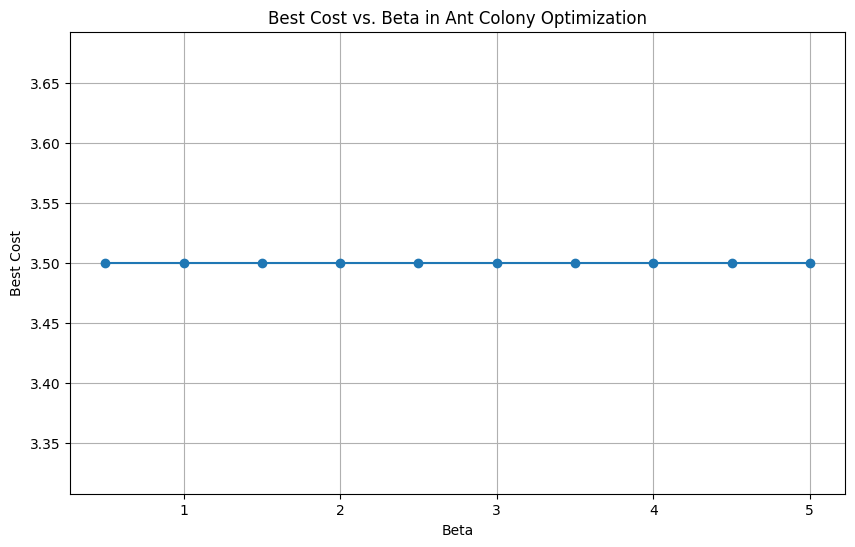

In [20]:
best_costs2 = []
for beta in beta_values:
    aco = AntColonyOptimization(
        num_customers, num_depots, num_plants, vehicle_capacity, depot_capacity, plant_capacity,
        distance_depot_to_customer2, distance_plant_to_depot2, demand_customers2, num_ants,
        num_iterations, alpha, beta, evaporation_rate, pheromone_initial
    )
    best_solution, best_cost = aco.run()
    best_costs2.append(best_cost)

plt.figure(figsize=(10, 6))
plt.plot(beta_values, best_costs2, marker='o', linestyle='-')
plt.xlabel('Beta')
plt.ylabel('Best Cost')
plt.title('Best Cost vs. Beta in Ant Colony Optimization')
plt.grid(True)
plt.show()

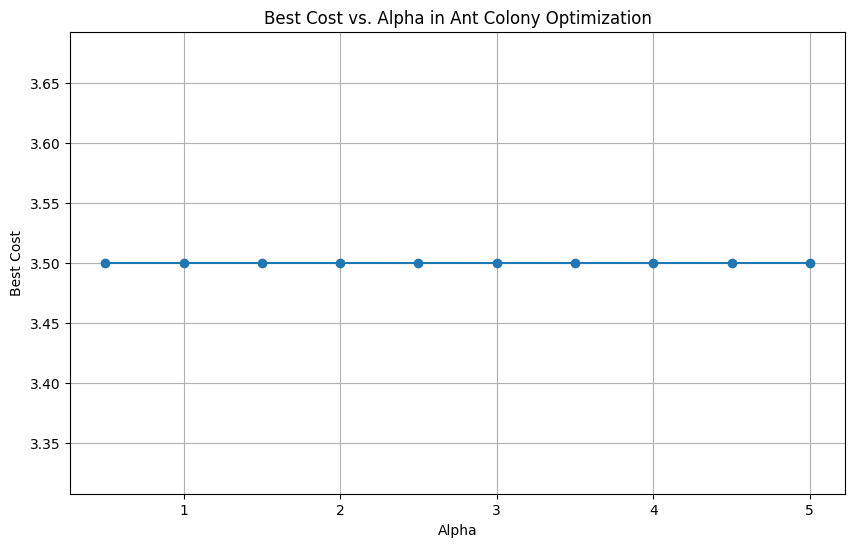

In [23]:
beta=2
alpha_costs2 = []
for alpha in alpha_values:
    aco = AntColonyOptimization(
        num_customers, num_depots, num_plants, vehicle_capacity, depot_capacity, plant_capacity,
        distance_depot_to_customer2, distance_plant_to_depot2, demand_customers2, num_ants,
        num_iterations, alpha, beta, evaporation_rate, pheromone_initial
    )
    best_solution, best_cost = aco2.run()
    alpha_costs2.append(best_cost)

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, alpha_costs2, marker='o', linestyle='-')
plt.xlabel('Alpha')
plt.ylabel('Best Cost')
plt.title('Best Cost vs. Alpha in Ant Colony Optimization')
plt.grid(True)
plt.show()

## Third Example

In [24]:
distance_depot_to_customer3 = np.random.rand(num_depots, num_customers)
distance_plant_to_depot3 = np.random.rand(num_plants, num_depots)
demand_customers3 = np.random.randint(5, 20, size=num_customers)

In [29]:
aco3=AntColonyOptimization(num_customers, num_depots, num_plants, vehicle_capacity, depot_capacity, plant_capacity, distance_depot_to_customer3, distance_plant_to_depot3,
                 demand_customers3,num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_initial)
best_solution3, best_cost3 = aco3.run()
print("Best solution:", best_solution3)
print("Best cost:", best_cost3)

Best solution: {'depot_to_customer': [(0, 0), (0, 2), (0, 5), (0, 9), (0, 4), (2, 1), (2, 6), (2, 8), (2, 7), (2, 3)], 'plant_to_depot': [(0, 0), (1, 2)]}
Best cost: 3.669640099296146


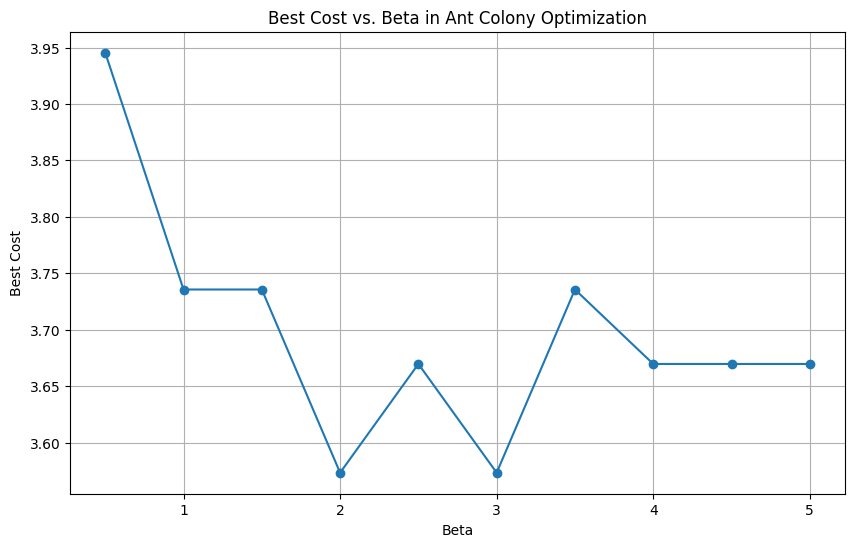

In [30]:
best_costs3 = []
for beta in beta_values:
    aco = AntColonyOptimization(
        num_customers, num_depots, num_plants, vehicle_capacity, depot_capacity, plant_capacity,
        distance_depot_to_customer3, distance_plant_to_depot3, demand_customers3, num_ants,
        num_iterations, alpha, beta, evaporation_rate, pheromone_initial
    )
    best_solution, best_cost = aco.run()
    best_costs3.append(best_cost)

plt.figure(figsize=(10, 6))
plt.plot(beta_values, best_costs3, marker='o', linestyle='-')
plt.xlabel('Beta')
plt.ylabel('Best Cost')
plt.title('Best Cost vs. Beta in Ant Colony Optimization')
plt.grid(True)
plt.show()

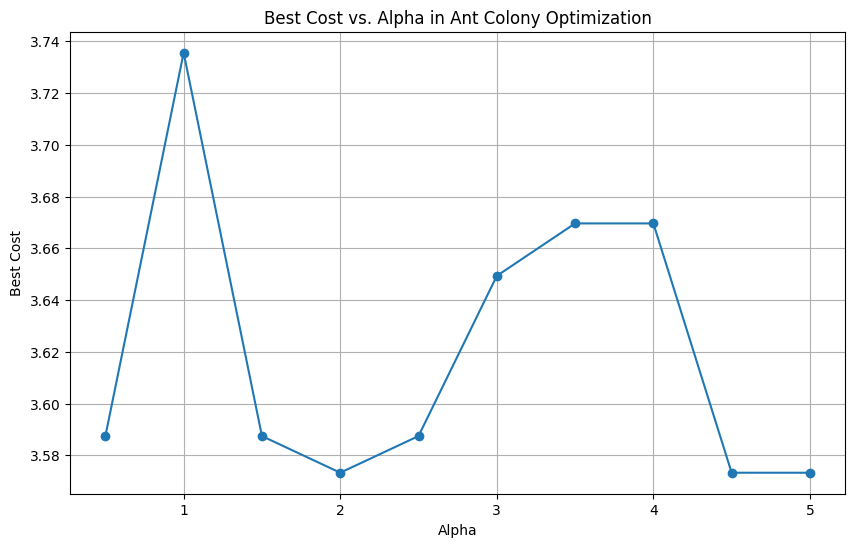

In [31]:
beta=2
alpha_costs3 = []
for alpha in alpha_values:
    aco = AntColonyOptimization(
        num_customers, num_depots, num_plants, vehicle_capacity, depot_capacity, plant_capacity,
        distance_depot_to_customer3, distance_plant_to_depot3, demand_customers3, num_ants,
        num_iterations, alpha, beta, evaporation_rate, pheromone_initial
    )
    best_solution, best_cost = aco.run()
    alpha_costs3.append(best_cost)

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, alpha_costs3, marker='o', linestyle='-')
plt.xlabel('Alpha')
plt.ylabel('Best Cost')
plt.title('Best Cost vs. Alpha in Ant Colony Optimization')
plt.grid(True)
plt.show()

In [32]:
beta=2
alpha=2
aco3=AntColonyOptimization(num_customers, num_depots, num_plants, vehicle_capacity, depot_capacity, plant_capacity, distance_depot_to_customer3, distance_plant_to_depot3,
                 demand_customers3,num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_initial)
best_solution3, best_cost3 = aco3.run()
print("Best solution:", best_solution3)
print("Best cost:", best_cost3)

Best solution: {'depot_to_customer': [(2, 6), (2, 3), (2, 1), (2, 8), (2, 7), (2, 2), (2, 4), (0, 9), (0, 0), (0, 5)], 'plant_to_depot': [(0, 0), (1, 2)]}
Best cost: 3.649351808648119


# Conclusion

We can conclude that $\alpha$ and $\beta$ impact the cost and the solution. As mentionned in multiple papers, there is no a conventional value for them, in general they are using $\beta=2$ and $\alpha=1$, but as we can see, each case has its own value to minimize the cost.